In [1]:
import networkx as nx
from cdlib import evaluation
from cdlib.classes import NodeClustering
import pickle
from cdlib import viz
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
import scipy.cluster.hierarchy as sch
from sklearn_extra.cluster import KMedoids

In [2]:
# NOTEBOOK CONFIGURATION
PROJECT_NAME = "jpetstore"
PROJECT_PATH = "../jpetstore"

In [3]:
GRAPH_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_128scenarios_nopolicies_sobol_graph.pkl"
java_graph = None
with open(GRAPH_FILENAME, 'rb') as f:
     java_graph = pickle.load(f)

java_graph.nodes(data=True)
java_graph.edges(data=True)

EdgeDataView([('AccountActionBean.java', 'AbstractActionBean.java', {'weight': 105}), ('AccountActionBean.java', 'Account.java', {'weight': 105}), ('AccountActionBean.java', 'AccountActionBean.java', {'weight': 20}), ('AccountActionBean.java', 'AccountService.java', {'weight': 25}), ('AccountActionBean.java', 'CatalogService.java', {'weight': 15}), ('AccountActionBean.java', 'AccountActionBeanTest.java', {'weight': 175}), ('AccountActionBean.java', 'OrderActionBean.java', {'weight': 20}), ('AbstractActionBean.java', 'AccountActionBeanTest.java', {'weight': 5}), ('AbstractActionBean.java', 'CartActionBean.java', {'weight': 105}), ('AbstractActionBean.java', 'CatalogActionBean.java', {'weight': 105}), ('AbstractActionBean.java', 'CatalogActionBeanTest.java', {'weight': 5}), ('AbstractActionBean.java', 'OrderActionBean.java', {'weight': 125}), ('AbstractActionBean.java', 'OrderActionBeanTest.java', {'weight': 5}), ('Account.java', 'AccountActionBeanTest.java', {'weight': 80}), ('Account.j

In [4]:
PARTITIONS_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_128scenarios_nopolicies_sobol_partitions.pkl"
partitions_dict = None
with open(PARTITIONS_FILENAME, 'rb') as f:
     partitions_dict = pickle.load(f)

print("partitions:", len(partitions_dict))

key_0 = list(partitions_dict.keys())[10]
partitions_dict[key_0]

partitions: 1205


{0: ['Order.java',
  'Account.java',
  'AccountActionBean.java',
  'LineItem.java',
  'ItemMapper.java',
  'CatalogService.java',
  'CartActionBean.java',
  'OrderActionBean.java',
  'CategoryMapper.java',
  'ProductMapper.java',
  'CatalogActionBean.java',
  'AbstractActionBean.java',
  'AccountService.java',
  'AccountMapper.java',
  'Cart.java',
  'Item.java',
  'CartItem.java',
  'Product.java',
  'SequenceMapper.java',
  'Sequence.java',
  'LineItemMapper.java',
  'OrderMapper.java',
  'OrderService.java'],
 1: ['ItemMapper.java',
  'CatalogService.java',
  'CartActionBean.java',
  'OrderActionBean.java',
  'CategoryMapper.java',
  'ProductMapper.java',
  'CatalogActionBean.java',
  'AbstractActionBean.java',
  'Order.java',
  'Account.java',
  'AccountActionBean.java',
  'LineItem.java',
  'AccountService.java',
  'AccountMapper.java',
  'Cart.java',
  'Item.java',
  'CartItem.java',
  'Product.java',
  'SequenceMapper.java',
  'Sequence.java',
  'LineItemMapper.java',
  'OrderMa

In [5]:
key_0 = list(partitions_dict.keys())[11]
n_partitions = list(partitions_dict[key_0].values())
print(len(n_partitions), "partitions")
n_clustering = NodeClustering(communities=n_partitions, graph=java_graph, overlap=True)

7 partitions


In [6]:
# Omega index indicates the similarity between two partitions
# If omega = 1, the two partitions are identical (distance = 0), and omega = 0 (distance = 1) is the opposite case
# Thus, omega works as a similarity index
def compute_omega_index(partition_i, partition_j, graph, distance=False):
    clustering_i = NodeClustering(communities=list(partition_i.values()), graph=graph, overlap=True)
    clustering_j = NodeClustering(communities=list(partition_j.values()), graph=graph, overlap=True)
    if distance:
        return 1 - evaluation.omega(clustering_i, clustering_j).score
    else:
        return evaluation.omega(clustering_i, clustering_j).score

def get_noise_classes(partition, graph):
    reference_class_set = set(list(graph.nodes()))
    partition_class_set = set([x for xs in partition.values() for x in xs])
    difference_set = reference_class_set.difference(partition_class_set)
    return difference_set

def update_partition_with_noise(partition, graph):
    noise_classes = get_noise_classes(partition, graph)
    if len(noise_classes) > 0:
        partition[-1] = list(noise_classes) # -1 is the key for the noise classes
    
    return partition

# Checking the number of classes of the whole project, versus the classes assigned to the partitions
reference_class_set = set(list(java_graph.nodes()))
print("Reference class set:", len(reference_class_set), 'classes')
lenght_noise_classes = set()
for k in partitions_dict.keys():
    n_noise = len(get_noise_classes(partitions_dict[k], java_graph))
    lenght_noise_classes.add(n_noise)
if len(lenght_noise_classes) == 1:
    print("All the partitions have the same noise classes", lenght_noise_classes)
else:
    print("Warning: The partitions have different numbers of noise classes!", min(lenght_noise_classes), max(lenght_noise_classes)) 

Reference class set: 41 classes
All the partitions have the same noise classes {17}


7


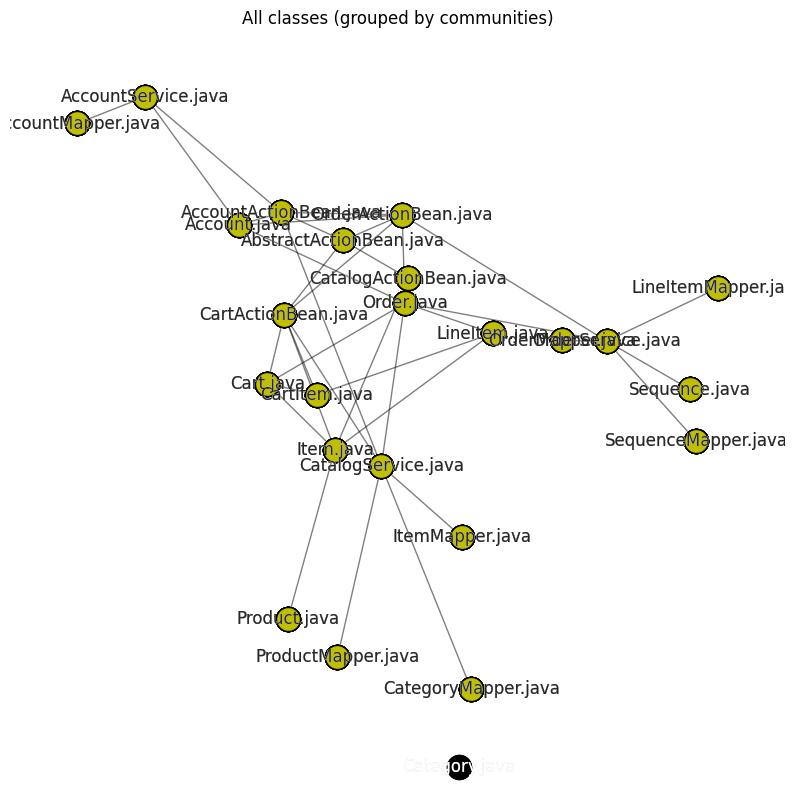

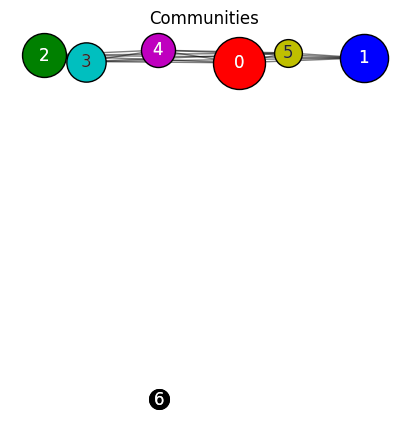

In [7]:
g = java_graph
lp_coms = n_clustering 
print(len(lp_coms.communities))
# TODO: Unsure if the chart is also showing classes belonging to more than one partition

pos = nx.fruchterman_reingold_layout(g) #nx.spring_layout(g)
#pos = nx.random_layout(g)
viz.plot_network_clusters(g, lp_coms, pos, figsize=(10, 10), plot_overlaps=False, plot_labels=True, node_size=300) #, top_k=3)
plt.title("All classes (grouped by communities)")
plt.show()

viz.plot_community_graph(g, lp_coms, figsize=(5, 5), plot_overlaps=True, plot_labels=True)
plt.title("Communities")
plt.show()

In [8]:
SIMILARITY_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_omega_scores.csv"

# Load distance matrix for partitions (omega)
partitions_distance_df = 1 - pd.read_csv(SIMILARITY_FILENAME, index_col=0)
print(partitions_distance_df.shape)
partitions_distance_df 

(1205, 1205)


,resolution_40_alpha_54_mfuzzy_5_mthreshold_10,resolution_40_alpha_88_mfuzzy_5_mthreshold_10,resolution_40_alpha_54_mfuzzy_4_mthreshold_10,resolution_40_alpha_54_mfuzzy_5_mthreshold_9,resolution_52_alpha_54_mfuzzy_5_mthreshold_10,resolution_52_alpha_54_mfuzzy_4_mthreshold_9,resolution_52_alpha_88_mfuzzy_5_mthreshold_9,resolution_52_alpha_88_mfuzzy_4_mthreshold_10,resolution_40_alpha_88_mfuzzy_4_mthreshold_9,resolution_52_alpha_88_mfuzzy_4_mthreshold_9,...,resolution_35_alpha_45_mfuzzy_9_mthreshold_6,resolution_33_alpha_45_mfuzzy_9_mthreshold_6,resolution_64_alpha_55_mfuzzy_6_mthreshold_5,resolution_64_alpha_51_mfuzzy_6_mthreshold_5,resolution_64_alpha_55_mfuzzy_6_mthreshold_10,resolution_62_alpha_55_mfuzzy_6_mthreshold_5,resolution_62_alpha_55_mfuzzy_6_mthreshold_10,resolution_62_alpha_51_mfuzzy_6_mthreshold_10,resolution_62_alpha_51_mfuzzy_6_mthreshold_5,resolution_64_alpha_51_mfuzzy_6_mthreshold_10
resolution_40_alpha_54_mfuzzy_5_mthreshold_10,0.000000,0.570248,0.837578,1.068327,0.695326,0.455794,0.646039,0.651255,0.547381,0.594059,...,0.885246,0.923077,0.885246,0.594059,0.885246,0.885246,0.885246,0.885246,0.885246,0.594059
resolution_40_alpha_88_mfuzzy_5_mthreshold_10,0.570248,0.000000,0.923740,0.974062,0.856624,0.808671,0.613160,0.758388,0.628967,0.838739,...,0.747198,0.923077,0.747198,0.838739,0.747198,0.747198,0.747198,0.747198,0.747198,0.838739
resolution_40_alpha_54_mfuzzy_4_mthreshold_10,0.837578,0.923740,0.000000,0.931288,0.578219,0.530289,0.925402,0.910846,0.850171,0.871775,...,0.910399,0.923077,0.910399,0.871775,0.910399,0.910399,0.910399,0.910399,0.910399,0.871775
resolution_40_alpha_54_mfuzzy_5_mthreshold_9,1.068327,0.974062,0.931288,0.000000,0.868155,1.068327,0.721100,1.068327,1.039616,0.923077,...,0.642857,0.875536,0.642857,0.923077,0.642857,0.642857,0.642857,0.642857,0.642857,0.923077
resolution_52_alpha_54_mfuzzy_5_mthreshold_10,0.695326,0.856624,0.578219,0.868155,0.000000,0.286337,0.639472,0.789552,0.882558,0.847308,...,0.909091,0.885246,0.909091,0.847308,0.909091,0.909091,0.909091,0.909091,0.909091,0.847308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
resolution_62_alpha_55_mfuzzy_6_mthreshold_5,0.885246,0.747198,0.910399,0.642857,0.909091,0.885246,0.906417,0.885246,0.863842,0.923077,...,0.000000,0.923077,0.000000,0.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.923077
resolution_62_alpha_55_mfuzzy_6_mthreshold_10,0.885246,0.747198,0.910399,0.642857,0.909091,0.885246,0.906417,0.885246,0.863842,0.923077,...,0.000000,0.923077,0.000000,0.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.923077
resolution_62_alpha_51_mfuzzy_6_mthreshold_10,0.885246,0.747198,0.910399,0.642857,0.909091,0.885246,0.906417,0.885246,0.863842,0.923077,...,0.000000,0.923077,0.000000,0.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.923077
resolution_62_alpha_51_mfuzzy_6_mthreshold_5,0.885246,0.747198,0.910399,0.642857,0.909091,0.885246,0.906417,0.885246,0.863842,0.923077,...,0.000000,0.923077,0.000000,0.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.923077


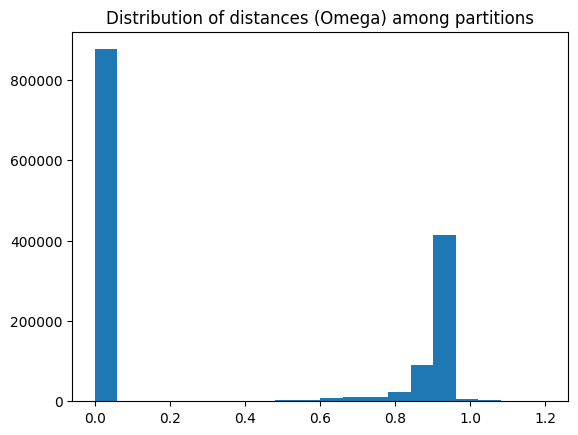

In [9]:
plt.hist(np.tril(partitions_distance_df).flatten(), bins=20)
plt.title("Distribution of distances (Omega) among partitions")
plt.show()

/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


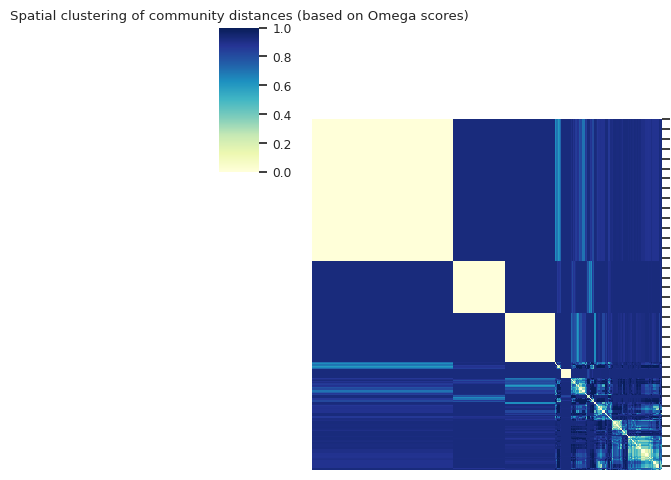

In [10]:
sns.set(font_scale=0.8)
ax = sns.clustermap(partitions_distance_df, cmap='YlGnBu', robust=True, method="average", 
                    figsize=(8,8), vmax=1, vmin=0)
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
ax.ax_heatmap.set_xticklabels([])
ax.ax_heatmap.set_yticklabels([])

plt.title("Spatial clustering of community distances (based on Omega scores)")
plt.show()

In [11]:
def plot_2d_embeddings(embeddings_2d=None, title="", distance_df=None, view="matplotlib", partitions_dict=None):

    if embeddings_2d is None:
        mds = MDS(dissimilarity='precomputed', random_state=0)
        embeddings_2d = mds.fit_transform(distance_df)

    if view == "matplotlib":
        #create scatterplot
        plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.3)
        #add axis labels
    
    else: # sns
        df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
        df['cluster size'] = [len(partitions_dict[k]) for k in partitions_dict.keys()]
        sns.scatterplot(data=df, x="x", y="y", hue="cluster size", palette="tab10", size="cluster size", 
                alpha=0.3, legend='full', sizes=(20, 200))


    #display scatterplot
    plt.title(title)
    plt.grid(False)
    plt.show()

In [12]:
# https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/

mds = MDS(dissimilarity='precomputed', random_state=0)
embeddings_2d_partitions = mds.fit_transform(partitions_distance_df)

/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


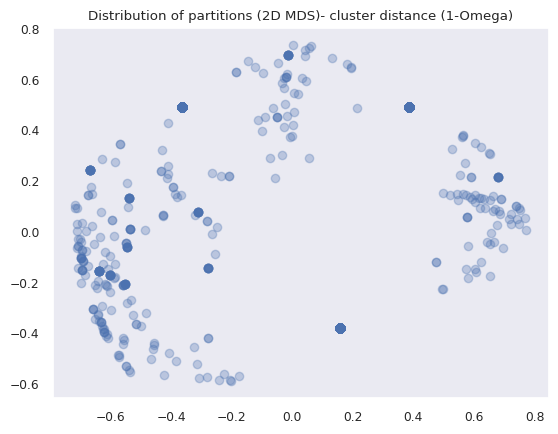

In [13]:
plot_2d_embeddings(embeddings_2d_partitions, title="Distribution of partitions (2D MDS)- cluster distance (1-Omega)")

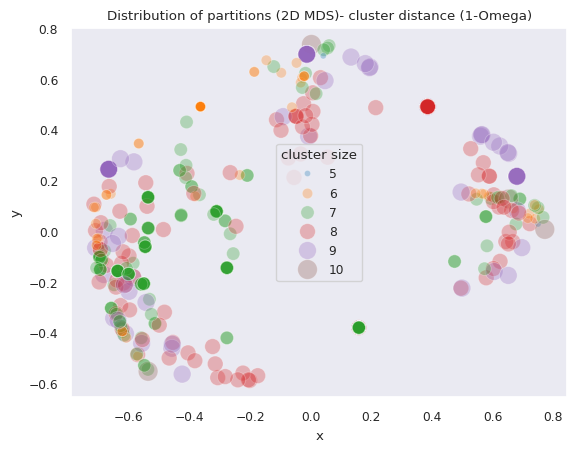

In [14]:
plot_2d_embeddings(embeddings_2d_partitions, title="Distribution of partitions (2D MDS)- cluster distance (1-Omega)",
                   view="sns", partitions_dict=partitions_dict)

In [15]:
# Agglomerative (hierarchical) clustering
def run_agglomerative(df, k, threshold=200, n_pca=None, normalize=False, show_dendogram=False, archstructure=None):

  if normalize:
    sample = StandardScaler().fit_transform(df)
  else:
    sample = df.values

  if n_pca is not None:
    pca = PCA(n_components=n_pca)
    sample_pca = sample # pca.fit_transform(sample)
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward',
                                    connectivity=archstructure, distance_threshold=threshold)
    model.fit(sample_pca)
    X = sample_pca
  else:
    # model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward',
    #                                 connectivity=archstructure, distance_threshold=threshold)
    model = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single',
                                  connectivity=archstructure, distance_threshold=threshold)
    model.fit(sample)
    X = sample
  labels = model.labels_
  print(f"Number of clusters = {1+np.amax(model.labels_)}")

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  #print('clusters:', clustering.labels_)
  fixed_labels = np.where(model.labels_ < 0, 0, model.labels_)

  print("Estimated number of clusters: %d" % n_clusters_)
  print("Estimated number of noise points: %d" % n_noise_)
  classes = set(fixed_labels)
  if len(classes) > 1:
    if n_pca is not None:
      silhouette = metrics.silhouette_score(sample_pca, fixed_labels)
    else:
      silhouette = metrics.silhouette_score(sample, fixed_labels)
  else:
    silhouette = 0.0
  print("Silhouette Coefficient: %0.3f" % silhouette)

  if show_dendogram:
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1, 1, 1)
    dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), ax=ax)
    plt.show()

  return fixed_labels, model, silhouette

In [16]:
# Agglomerative clustering using the distance matrix of partitions
partition_labels, _, silhouette = run_agglomerative(partitions_distance_df, k=4, threshold=None, show_dendogram=False)

classes = set(partition_labels)
print(silhouette, len(classes))

Number of clusters = 4
Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: -0.062
-0.06216209783019369 4


/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of clusters = 5
Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.796


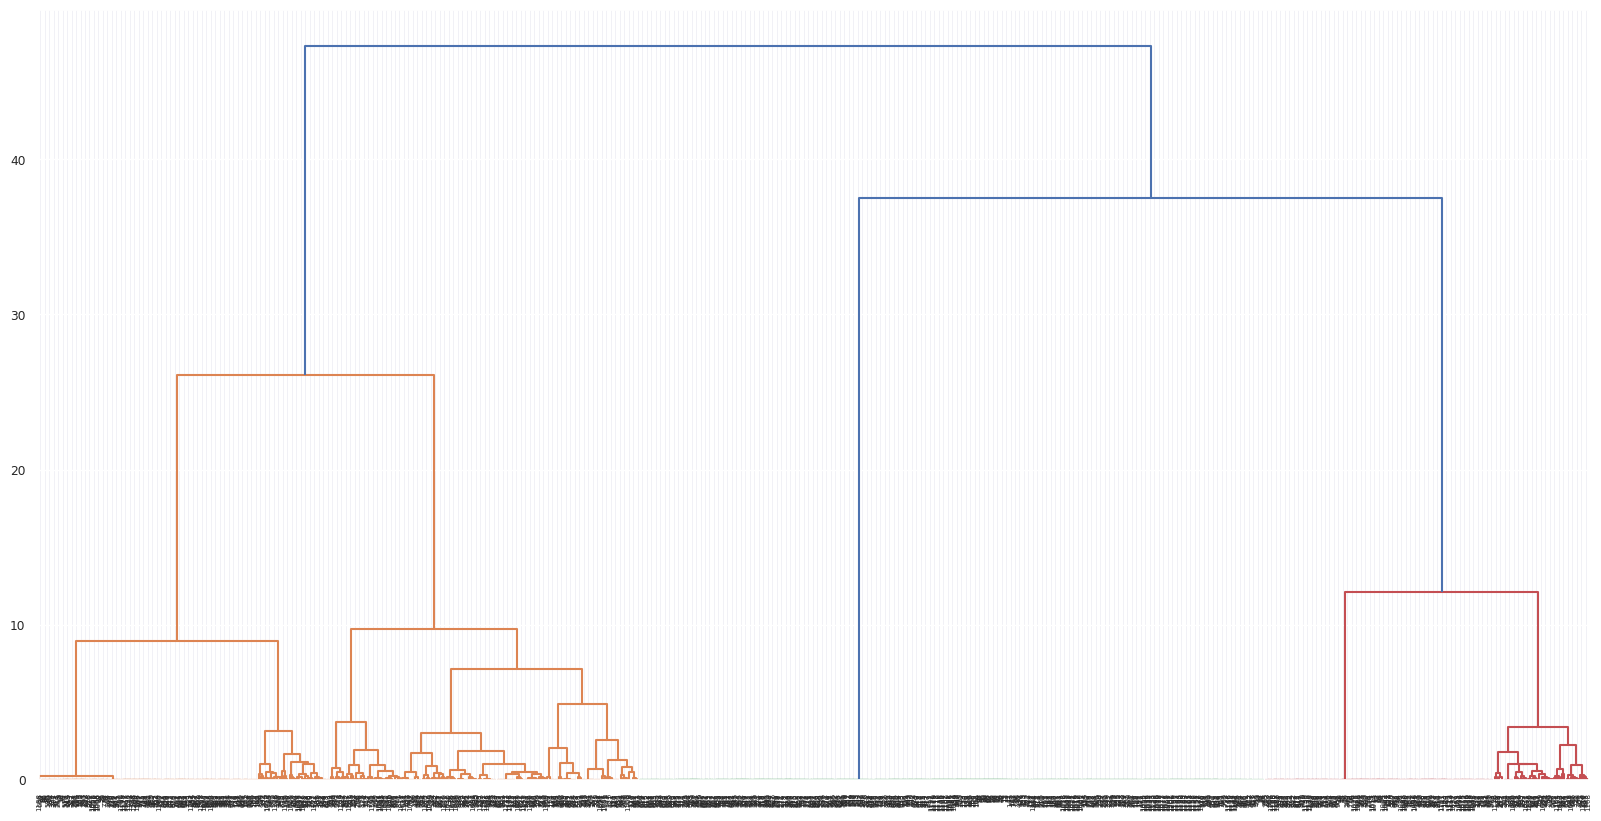

0.7962004988480029 5


In [17]:
# Alternative using agglomerative clustering but on the MDS 2D embeddings
partition_labels_2d, _, silhouette = run_agglomerative(embeddings_2d_partitions, k=5, threshold=None, 
                                                       show_dendogram=True, normalize=True, n_pca=2)

classes = set(partition_labels_2d)
print(silhouette, len(classes))

In [18]:
def select_medoids_from_clusters(embeddings_2d, partition_labels, distance_df):
    # Visit each cluster and select a medoid (representative) for each
    classes = set(partition_labels)
    medoids = []
    medoid_labels = []
    for c in classes:
        print("Cluster:", c)
        cluster_indices = [i for i, x in enumerate(partition_labels) if x == c]
        print("   ", len(cluster_indices), "elements")
        cluster_distances = []
        for i in cluster_indices:
            cluster_distances.append(np.sum(distance_df.iloc[i, cluster_indices]))
        idx = cluster_indices[np.argmin(cluster_distances)]
        print("   medoid:", idx, distance_df.columns[idx])
        medoid_labels.append(distance_df.columns[idx])
        # TODO: Use instead as below
        kmodel = KMedoids(n_clusters=1, method='pam').fit(embeddings_2d[cluster_indices])
        medoids.extend(kmodel.cluster_centers_) # print(kmodel.medoid_indices_)

    return medoids, medoid_labels

In [19]:
coordinates_2d, m_labels = select_medoids_from_clusters(embeddings_2d_partitions, partition_labels_2d, partitions_distance_df)
print(coordinates_2d)
print(m_labels)

Cluster: 0
    239 elements
   medoid: 180 resolution_89_alpha_14_mfuzzy_2_mthreshold_4
Cluster: 1
    227 elements
   medoid: 9 resolution_52_alpha_88_mfuzzy_4_mthreshold_9
Cluster: 2
    487 elements
   medoid: 11 resolution_61_alpha_19_mfuzzy_7_mthreshold_5
Cluster: 3
    74 elements
   medoid: 1042 resolution_91_alpha_44_mfuzzy_2_mthreshold_6
Cluster: 4
    178 elements
   medoid: 16 resolution_31_alpha_19_mfuzzy_7_mthreshold_5
[array([-0.5860792 , -0.12577747]), array([-0.36397072,  0.4909123 ]), array([ 0.15884095, -0.37961566]), array([0.63774409, 0.09462448]), array([0.38584758, 0.49073589])]
['resolution_89_alpha_14_mfuzzy_2_mthreshold_4', 'resolution_52_alpha_88_mfuzzy_4_mthreshold_9', 'resolution_61_alpha_19_mfuzzy_7_mthreshold_5', 'resolution_91_alpha_44_mfuzzy_2_mthreshold_6', 'resolution_31_alpha_19_mfuzzy_7_mthreshold_5']


/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(
/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(
/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(
/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:252: UserWarning: n_clusters should be larger than 2 if max_iter != 0 setting max_iter to 0.
  warnings.warn(
/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn_ext

In [20]:
def get_xy_coordinates(labels, embeddings_2d, distance_df):
    xy_coordinates = []
    for lb in labels:
        idx = list(distance_df.columns).index(lb)
        xy_coordinates.append(embeddings_2d[idx])
    return xy_coordinates


def show_clusters(embeddings_2d, partition_labels, medoid_labels=[], distance_df=None, title="", 
                  show_labels=False, alpha=0.3, size=(8,8)):

    fig = plt.figure(figsize=size)
    df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    df['cluster'] = partition_labels 
    ax = sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10", alpha=alpha, legend='full', sizes=(20, 200))
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    if len(medoid_labels) > 0:
        medoids = np.array(get_xy_coordinates(medoid_labels, embeddings_2d, distance_df))
        ax.plot(medoids[:,0], medoids[:,1], 'X', markersize=9, alpha=0.7, color='black')
        # Annotate the labels
        if show_labels:
            for idx, lb in enumerate(medoid_labels):
                ax.annotate(lb, (medoids[idx,0], medoids[idx,1]))
    
    plt.grid(False)
    plt.title(title)
    plt.show()

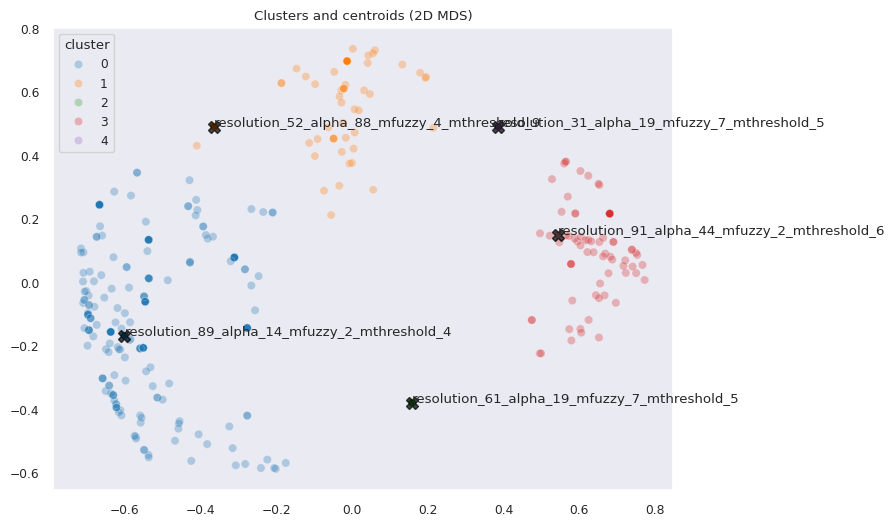

In [21]:
show_clusters(embeddings_2d_partitions, partition_labels_2d, distance_df=partitions_distance_df, size=(8,6),
                            title="Clusters and centroids (2D MDS)", medoid_labels=m_labels, show_labels=True)

208 stable solutions
range: 0.125 0.1796875


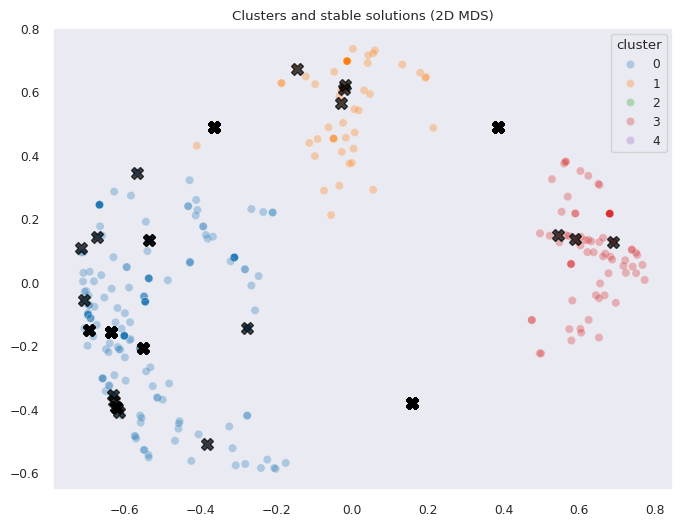

In [22]:
STABLE_SOLUTIONS_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_stable_solutions.pkl"

other_labels=[]
stable_solutions_dict = None
with open(STABLE_SOLUTIONS_FILENAME, 'rb') as f:
     stable_solutions_dict = pickle.load(f)
     other_labels = stable_solutions_dict.keys()
     print(len(other_labels), "stable solutions")
     values = list(stable_solutions_dict.values())
     print("range:", min(values), max(values))


show_clusters(embeddings_2d_partitions, partition_labels_2d, distance_df=partitions_distance_df, size=(8,6),
                            title="Clusters and stable solutions (2D MDS)", medoid_labels=other_labels, show_labels=False)

Computing parameter distances ...
(1205, 1205)
min-max distances: 0.01010101010101 1.7090419555039866


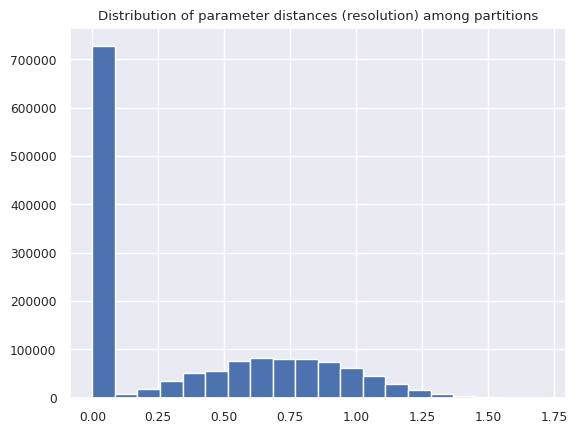

In [23]:
DISTANCE_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_parameter_distances.csv"

print("Computing parameter distances ...")
resolution_distance_df = pd.read_csv(DISTANCE_FILENAME, index_col=0)

print(resolution_distance_df.shape)
resolution_distance_np = np.tril(resolution_distance_df).flatten()
min_non_zero = np.min(resolution_distance_np[np.nonzero(resolution_distance_np)])
print("min-max distances:", min_non_zero, resolution_distance_np.max())

plt.hist(resolution_distance_np, bins=20)
plt.title("Distribution of parameter distances (resolution) among partitions")
plt.show()

/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


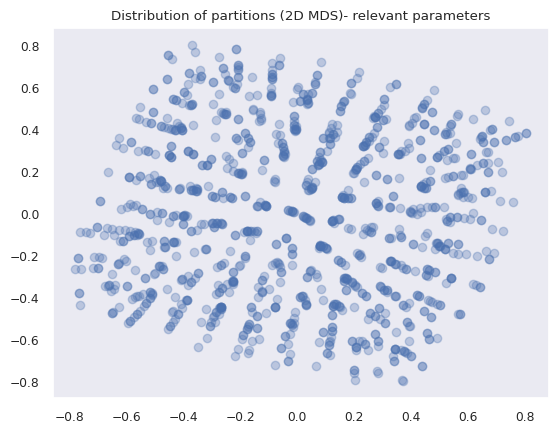

In [24]:
plot_2d_embeddings(title="Distribution of partitions (2D MDS)- relevant parameters", distance_df=resolution_distance_df)

In [25]:
from ema_workbench import load_results

def calculate_stability(row, stable_solutions_dict, default_value=0.0):
    lb = 'resolution_'+str(row['resolution'])+'_alpha_'+str(row['alpha'])+'_mfuzzy_'+str(row['mfuzzy'])+'_mthreshold_'+str(row['microservice_threshold'])
    if lb in stable_solutions_dict.keys():
        return stable_solutions_dict[lb]
    return default_value


MODEL_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_128scenarios_nopolicies_sobol" #.tar.gz'

ALL_PARAMETERS = ['alpha',  'mfuzzy',  'microservice_threshold',  'resolution']

experiments_df, outcomes = load_results(MODEL_FILENAME+ '.tar.gz')
print(experiments_df.shape)
experiments_df = experiments_df[ALL_PARAMETERS].drop_duplicates(keep='first')
experiments_df['stability'] = experiments_df.apply(lambda x: calculate_stability(x,stable_solutions_dict), axis=1)
print(experiments_df.shape)

relevant_parameters = ['resolution', 'mfuzzy', 'microservice_threshold', 'stability'] # ['resolution'] # ALL_PARAMETERS

experiments_df = experiments_df[relevant_parameters]
experiments_df

(1280, 7)
(1205, 5)


/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


,resolution,mfuzzy,microservice_threshold,stability
0,40,5,10,0.0
1,40,5,10,0.0
2,40,4,10,0.0
3,40,5,9,0.0
4,52,5,10,0.0
...,...,...,...,...
1274,62,6,5,0.0
1275,62,6,10,0.0
1276,62,6,10,0.0
1277,62,6,5,0.0


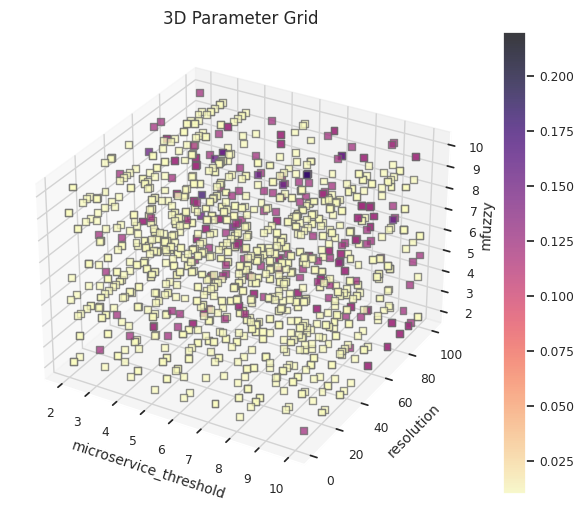

In [26]:
from matplotlib.colors import LogNorm

# https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
# https://pythonnumericalmethods.berkeley.edu/notebooks/chapter12.02-3D-Plotting.html

plt.rcParams['grid.color'] = "lightgray"

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
experiments_df.sort_values('stability', inplace=True) # To plot it correctly
zdata = experiments_df['mfuzzy'].tolist() # 15 * np.random.random(100)
xdata = experiments_df['microservice_threshold'].tolist() # np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = experiments_df['resolution'].tolist() # np.cos(zdata) + 0.1 * np.random.randn(100)
# ax.grid(False)
ax.set_facecolor('white')
#p3d = ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens', s=50)
stability_values = experiments_df['stability'].tolist()
norm_color = LogNorm(vmin=min(stability_values), vmax=max(stability_values))
p3d = ax.scatter3D(xdata, ydata, zdata, c=stability_values, s=25, cmap='magma_r', alpha=0.75, edgecolors='dimgrey', marker='s',
                   vmin=0.01, vmax=0.22) #zorder=stability_values)
plt.colorbar(p3d)

ax.set_title('3D Parameter Grid', fontsize=12)
ax.set_xlabel('microservice_threshold', fontsize=10)
ax.set_ylabel('resolution', fontsize=10)
ax.set_zlabel('mfuzzy', fontsize=10, rotation=0)
ax.zaxis.labelpad=-3 # <- change the value here
# The fix
for spine in ax.spines.values():
    spine.set_visible(True)
# plt.tight_layout()
plt.show()

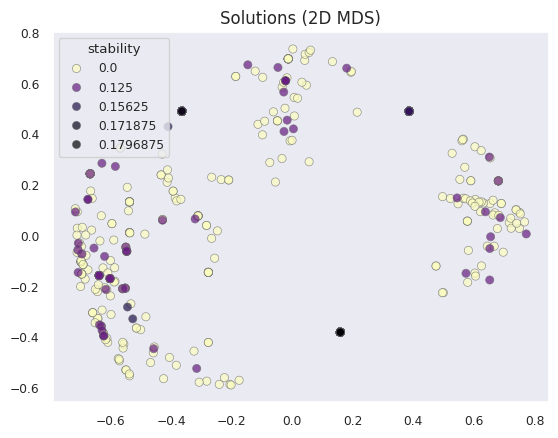

In [27]:
df = pd.DataFrame(embeddings_2d_partitions, columns=['x', 'y'])
df['stability'] = experiments_df['stability'].tolist()
df.sort_values('stability', inplace=True) # To plot it correctly
ax = sns.scatterplot(data=df, x="x", y="y", hue="stability", palette="magma_r", edgecolors='dimgrey',  alpha=0.7, s=35, marker='o')
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_title('Solutions (2D MDS)', fontsize=12)
plt.grid(False)
plt.show()